In [1]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

import glob, re, os, sys, random
from random import shuffle
import random
from time import time

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

# Modeling - Logistic, XGBOOST, SVM
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

from sklearn.pipeline import Pipeline, FeatureUnion

from xgboost import XGBClassifier
import pickle


In [2]:
import sys
sys.path.append(f'../../../python')
from grid_search import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, \
create_feature_label, gridsearch, fit_best_model_train, evaluate, fit_best_model_test, \
train_model_cross_val, train_model_test, \
get_feature_importance_cv, get_feature_importance, get_feature_importance10

### Load data

In [420]:
df = pd.read_json(r"../../../../data/processed/pre-processed_2023_03_20.json")

### Balance data and split to train and test set

In [422]:
label_name = "phase2"

In [423]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded)
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded)

Total decisions: 1583
0    1485
1      98
Name: label, dtype: int64
Balancing...
Total decisions: 196
Labels distribution: 
 0    98
1    98
Name: 0, dtype: int64
Training set shape: (157,) (157,)
Test set shape: (40,) (40,)
Creating df_train 1: 78 0: 79
Creating df_test1 1: 20 0: 20
Creating df_test concatenated with df_excluded with len: 1386
Creating df_test 1: 20 0: 1406
Grouping df_train by case_num 1: 78 0: 79
Grouping df_test by case_num 1: 20 0: 1406
Grouping df_test1 by case_num 1: 20 0: 20
Grouping df_excluded by case_num with len: 1386


In [424]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped)

### Hyperparameter tuning with GridSearch Cross Validation

In [8]:
# Define model
solver='liblinear'
model = LogisticRegression(solver=solver)

# Create a pipeline with TfidfVectorizer and Model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', max_features=5000, stop_words='english')),
    ('clf', model)

])

# Define the grid of hyperparameters to search over
parameters = {
    'tfidf__ngram_range': [(2,2),(2,3), (2,4), (3,3), (3,4)], #(1,2),(1,1),(1,3),
    #'tfidf__analyzer': ('word', 'char'),
    #'tfidf__lowercase': (True, False),
    'tfidf__max_df': [0.01, 0.02, 0.05], # (0.01, 1.0), # ignore words that occur as more than x% of corpus
    # 'tfidf__min_df': (1, 2, 3), # we need to see a word at least (once, twice, thrice) in a document
    'tfidf__use_idf': (False, True), # use inverse document frequency weighting
    #'tfidf__sublinear_tf': (False, True),
    'tfidf__binary': (False, True), #set term frequency binary (all non-zero terms are set to 1)
    'tfidf__norm': ('l1', 'l2'), #norm used to normalize term vectors
    # 'tfidf__max_features': (None, 2000, 5000),
    #'tfidf__stop_words': (None, 'english'),

    # 'clf__solver': ['liblinear', 'lbfgs'],
    'clf__C':(0.1, 1, 5) # penalty parameter for the model
}

In [10]:
grid_search, best_parameters = gridsearch(pipeline, parameters, X_train, y_train, cv=3, scoring='f1')

Fitting 3 folds for each of 768 candidates, totalling 2304 fits
done in 4093.514s
Best cross-validation score:  0.9325116713352007
Best parameters set:
	clf__C: 5
	tfidf__binary: True
	tfidf__max_df: 0.25
	tfidf__ngram_range: (1, 3)
	tfidf__norm: 'l2'
	tfidf__use_idf: True


##### Model fitting and evaluation

In [74]:
pipeline_cv, y_predict_cv = fit_best_model_train(X_train, y_train, model, best_parameters, cv=3)

fitting the best model
Accuracy: 0.930379746835443

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93        80
           1       0.92      0.94      0.93        78

    accuracy                           0.93       158
   macro avg       0.93      0.93      0.93       158
weighted avg       0.93      0.93      0.93       158


CR: (0.9303797468354431, 0.930448717948718, 0.9303769578976887, None)

Confusion matrix:
 [[74  6]
 [ 5 73]] 

_______________________


 Accuracy: 93.04 
 Precision: 0.924 
 Recall: 0.936 
 F1: 0.930


In [76]:
evaluate(y_train, y_predict_cv)

Accuracy: 0.930379746835443

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93        80
           1       0.92      0.94      0.93        78

    accuracy                           0.93       158
   macro avg       0.93      0.93      0.93       158
weighted avg       0.93      0.93      0.93       158


CR: (0.9303797468354431, 0.930448717948718, 0.9303769578976887, None)

Confusion matrix:
 [[74  6]
 [ 5 73]] 

_______________________


 Accuracy: 93.04 
 Precision: 0.924 
 Recall: 0.936 
 F1: 0.930


Saving the features and coefficients into a dataframe determined by gridsearchCV best_parameters.

In [102]:
df_features_cv = get_feature_importance_cv(pipeline_cv)
df_features_cv.to_excel('../../../../output/tables/features_logit_cv_full.xlsx', index=True)
df_features_cv.head()

,feature,importance
1691,europese,-0.805246
600,commissie,-0.805246
429,brussel,-0.805246
1692,europese commissie,-0.805246
434,bruxelles,-0.790418


In [75]:
y_predict_cv_test = fit_best_model_test(X_test, y_test, pipeline_cv)

testing on test set
Accuracy: 0.9482517482517483

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97      1409
           1       0.20      0.86      0.33        21

    accuracy                           0.95      1430
   macro avg       0.60      0.90      0.65      1430
weighted avg       0.99      0.95      0.96      1430


CR: (0.6000050272729558, 0.9033762546892425, 0.6501818181818182, None)

Confusion matrix:
 [[1338   71]
 [   3   18]] 

_______________________


 Accuracy: 94.83 
 Precision: 0.202 
 Recall: 0.857 
 F1: 0.327


### Model training (with 10-fold CV) using *best/chosen* parameters from GridSearch

Set parameters based on grdisearch or choose parameters to set

In [66]:
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__C: 5
	tfidf__binary: True
	tfidf__max_df: 0.25
	tfidf__ngram_range: (1, 3)
	tfidf__norm: 'l2'
	tfidf__use_idf: True


In [459]:
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, stop_words='english', ngram_range = (1,3), binary = True, max_df = 0.025, norm = 'l2', use_idf = True))
c = 5
solver = 'liblinear'
model=LogisticRegression(C=c, solver=solver)

In [460]:
pipeline_train, trained_model, y_predict_train = train_model_cross_val(X_train, y_train, vec=vec, model=model, cv=10)

***10-fold cross-validation***
Accuracy: 0.7961783439490446

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80        79
           1       0.81      0.77      0.79        78

    accuracy                           0.80       157
   macro avg       0.80      0.80      0.80       157
weighted avg       0.80      0.80      0.80       157


CR: (0.7969716704656464, 0.7960077896786758, 0.7959714100064978, None)

Confusion matrix:
 [[65 14]
 [18 60]] 

_______________________


 Accuracy: 79.62 
 Precision: 0.811 
 Recall: 0.769 
 F1: 0.789


In [461]:
pipeline_test, y_predict_test = train_model_test(X_train, y_train, X_test, y_test, model=model, vec=vec)

***testing on test set***
Accuracy: 0.8516445066480056

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92      1409
           1       0.08      0.90      0.15        20

    accuracy                           0.85      1429
   macro avg       0.54      0.88      0.53      1429
weighted avg       0.99      0.85      0.91      1429


CR: (0.5386410447434156, 0.8754790631653655, 0.5319676183413669, None)

Confusion matrix:
 [[1199  210]
 [   2   18]] 

_______________________


 Accuracy: 85.16 
 Precision: 0.079 
 Recall: 0.900 
 F1: 0.145


In [476]:
pipeline_test1, y_predict_test1 = train_model_test(X_train, y_train, X_test1, y_test1, model=model, vec=vec)

***testing on test set***
Accuracy: 0.925

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       0.95      0.90      0.92        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40


CR: (0.9260651629072681, 0.925, 0.924953095684803, None)

Confusion matrix:
 [[19  1]
 [ 2 18]] 

_______________________


 Accuracy: 92.50 
 Precision: 0.947 
 Recall: 0.900 
 F1: 0.923


### Feature importance

In [462]:
df_features_train, feature_importance, feature_names = get_feature_importance(trained_model, pipeline_train)
df_features_train.head(10)

,feature,importance,abs_importance
3931,requested examined,-1.199247,1.199247
1737,exceeding eur million,0.917236,0.917236
2957,member state operation,-0.896385,0.896385
18,active retail sale,-0.849178,0.849178
430,billion aggregate community,-0.751640,0.751640
1560,engaged production,-0.751182,0.751182
4241,sh,0.742808,0.742808
4876,view oems,-0.727875,0.727875
1738,exceeds cid,-0.713603,0.713603
1739,exceeds cid million,-0.713603,0.713603


In [463]:
# df_features_train = df_features_train.sort_values(by='abs_importance', ascending=False)
# df_features_train_top10 = df_features_train.nlargest(10, 'abs_importance') #importance

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.bar(df_features_train_top10['feature'], df_features_train_top10['importance'], color='darkgreen')
# ax.set_xlabel('Importance')
# ax.set_title('Top 10 Features by Absolute Importance')

# plt.show()


Get features for label = 1 and label = 0

In [464]:
df_features_train1, df_features_train0 = get_feature_importance10(df_features_train)

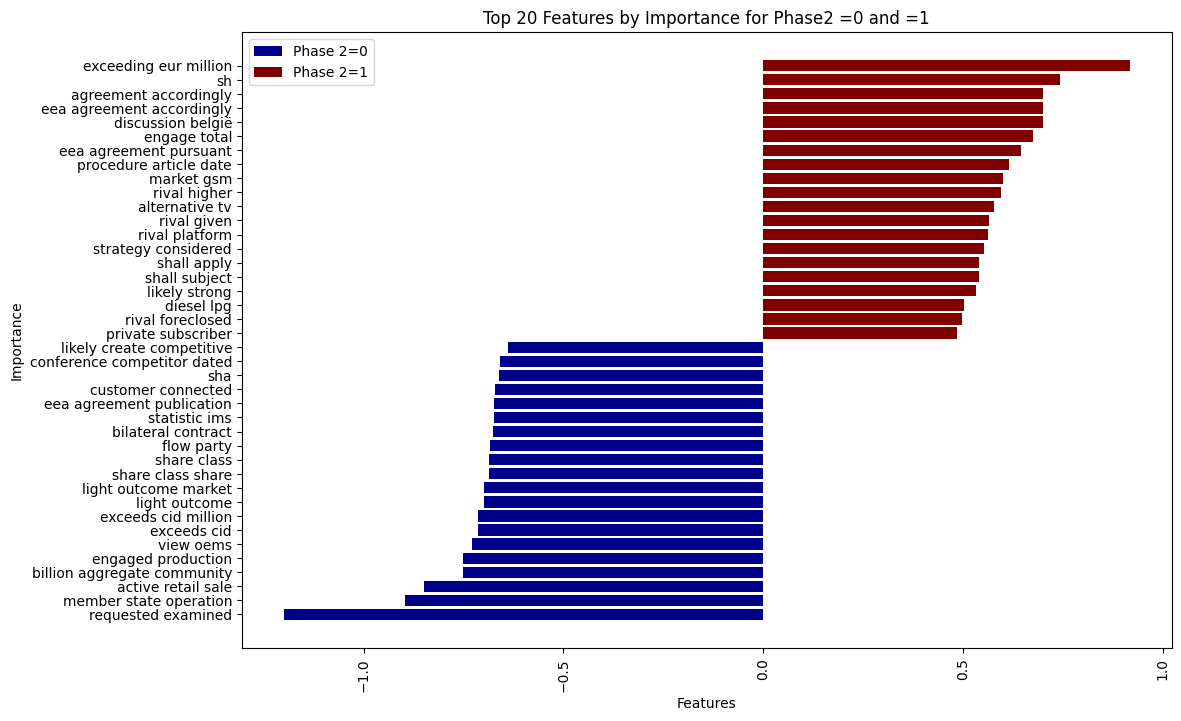

In [472]:
# Sort the features by absolute importance for label=1
df_features_train1 = df_features_train1.sort_values(by='abs_importance', ascending=False)
df_features_train1_top10 = df_features_train1.nlargest(20, 'abs_importance')
df_features_train1_top10 = df_features_train1_top10.sort_values('importance', ascending=True)

# Sort the features by absolute importance for label=0
df_features_train0 = df_features_train0.sort_values(by='abs_importance', ascending=False)
df_features_train0_top10 = df_features_train0.nlargest(20, 'abs_importance')

# Create a combined bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(df_features_train0_top10['feature'], df_features_train0_top10['importance'], color='darkblue', label='Phase 2=0')
ax.barh(df_features_train1_top10['feature'], df_features_train1_top10['importance'], color='maroon', label='Phase 2=1')
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Top 20 Features by Importance for Phase2 =0 and =1')
ax.legend()
plt.xticks(rotation=90)
plt.show()


In [473]:
df_features_train.to_excel('../../../../output/tables/features_logit_train_full_baseline.xlsx', index=True)

In [475]:
df_train_grouped

,year,case_num,file,article_new,label,text_clean
0,2004,M.3476,\m3476_20041028_20310_en,article6(1)(b),0,horizontal overlap case comp m danish crown st...
1,2004,M.3571,\m3571_20041118_20310_en,article6(1)(b),0,party submitted data year basis sale party add...
2,2005,M.3511,\m3511_20050322_20310_en,article6(1)(b),0,approximately million euro hvb group share bce...
3,2005,M.3556,\m3556_20050119_20310_en,article6(1)(b),0,product market definition joint venture active...
4,2005,M.3595,\m3595_20050330_20310_en,article6(1)(b),0,proposed operation constitutes concentration m...
...,...,...,...,...,...,...
152,2021,M.10123,\m10123_404_3,article6(1)(b),0,party active manufacture wholesale supply deco...
153,2021,M.10450,\M_10450_8093401_193_3,article6(1)(b),0,specific change brought transaction open fiber...
154,2021,M.9820,\M_9820_8034733_3778_3,article8(2),1,annex analysis party ’ opportunity data submit...
155,2021,M.9971,\M_9971_8045489_693_3,article6(1)(b),0,assessment horizontal effect transaction give ...
